# Finding The Best Strategy to Win Chess.com League Points Through Simulation

### In the following notebook we take a monte carlo approach to ask the question: what is the best way to maximize trophies earned with playing time?

### Chess.com released their league system to the public (you can find more here [chess.com link](https://www.chess.com/leagues)), but it looks like the tropies earned don't seem to be completely balanced. For starters, it is uniquely optimal to participate in arenas. You get your arena points as bonus trophies and you get bonus points for win streaks. Rapid games seem to be a bit underpointed as well. So what we'll do to test strategies is run a simulation of different winning percentages for the different arenas and time controls.

### To get an estimate of how long games take we'll scrape from the public chess.com API and randomly sample from those games to get an approximation of an arena. While this method is not entirely realistic (people speed up at the end of arenas and not all these games are from arenas), iterations can be made for more accurate results.

In [ ]:
!pip install chess.com seaborn chess matplotlib

In [249]:
START_USER = 'rdubwiley1990'
MONTHS_TO_PULL = [
    {'year':'2021', 'month':'12'},
    {'year':'2021', 'month':'11'},
]

### The following is a scraper I made to get games around the start user's ELO for each time control. The way it works is it pulls all the user's games for the given months and then takes the first user they've played and scrape their games (and so on). If for some reason we hit a dead end, we go back to the start user and find the next person who we haven't found.

### We pull the quickest time controls for each game type (1+0, 3+0, 10+0).

In [250]:
from chessdotcom import get_player_games_by_month, get_player_games_by_month_pgn
import nest_asyncio


def get_games(username, month_list):
    all_games = []
    for month_data in month_list:
        games = get_player_games_by_month(username, year=month_data['year'], month=month_data['month']).games
        all_games += games
    return all_games


def get_game_data(games, time_control):
    #Need to remove abandoned games and games that end because of end of arena
    return [ 
        game for game in games if game.time_control == time_control and game.white.result not in 
            ("abandoned","timevsinsufficient") and game.rules == 'chess'
    ]
    

def get_other_user(game, username):
    if game.white.username == username:
        return game.black.username
    else:
        return game.white.username


def scrape_games(start_user, time_control, num_games, months_to_pull, check_print = 250):
    found_games = []
    checked_users = set()
    found_game_ids = set()
    current_user = start_user
    while True:
        if len(found_games) >= num_games:
            break
        next_user = None
        checked_users.add(current_user)
        games = get_games(current_user, months_to_pull)
        filtered_games = get_game_data(games, time_control)
        filtered_games = [ game for game in filtered_games if game.uuid not in found_game_ids ]
        if len(filtered_games) == 0:
            other_users = [ get_other_user(game, current_user) for game in games ]
            for user in other_users:
                if user not in checked_users:
                    next_user = user
                    continue
            if not next_user:
                print("Unable to scrape to find games")
                break
        for game in filtered_games:
            if game.uuid not in found_game_ids:
                found_games.append(game)
                found_game_ids.add(game.uuid)
                if len(found_games) == num_games:
                    break
                elif len(found_games) % check_print == 0:
                    print(f"found {len(found_games)}")
                if not next_user:
                    other_user = get_other_user(game, current_user)
            else:
                print(f"Already found {game.uuid}")
        if next_user is None:
            next_user = start_user
        current_user = next_user
    return found_games
        

nest_asyncio.apply()


bullet_games = scrape_games(START_USER, "60", 1500, MONTHS_TO_PULL)
print(f"found {len(bullet_games)} bullet games")
blitz_games = scrape_games(START_USER, "180", 1500, MONTHS_TO_PULL)
print(f"found {len(blitz_games)} blitz games")
rapid_games = scrape_games(START_USER, "600", 1500, MONTHS_TO_PULL)
print(f"found {len(rapid_games)} rapid games")

found 250
found 500
found 750
found 1000
found 1250
found 1500 bullet games
found 250
found 500
found 750
found 1000
found 1250
found 1500 blitz games
found 250
found 500
found 750
found 1000
found 1250
found 1500 rapid games


### As said before, our method for sampling game times is using our pulled games and randomly choosing one as the time, so we do that with each of our game groupings.

In [266]:
from datetime import timedelta
import io
import time

import chess.pgn


def parse_time(time_str):
    strp_time = time.strptime(time_str, "%H:%M:%S")
    return timedelta(hours=strp_time.tm_hour, minutes=strp_time.tm_min, seconds=strp_time.tm_sec)


def get_game_length(game):
    pgn_str = io.StringIO(game.pgn)
    pgn = chess.pgn.read_game(pgn_str)
    start_time = parse_time(pgn.headers['UTCTime'])
    end_time = parse_time(pgn.headers['EndTime'])
    return (end_time - start_time).seconds
    
bullet_times = [ get_game_length(game) for game in bullet_games ]
blitz_times = [ get_game_length(game) for game in blitz_games ]
rapid_times = [ get_game_length(game) for game in rapid_games ]

### Each of time distributions for our game types are plotted below.

### Bullet games are almost all distributed near full time (120 secs), but there is a leftward tail (likely quick checkmates).

### Blitz games are similar, but a little more flat, and rapid games are much flatter.

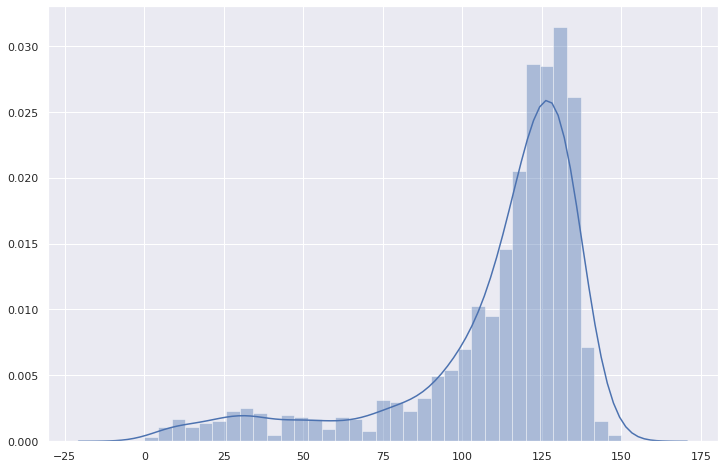

In [252]:
import seaborn as sns

sns.distplot(bullet_times)

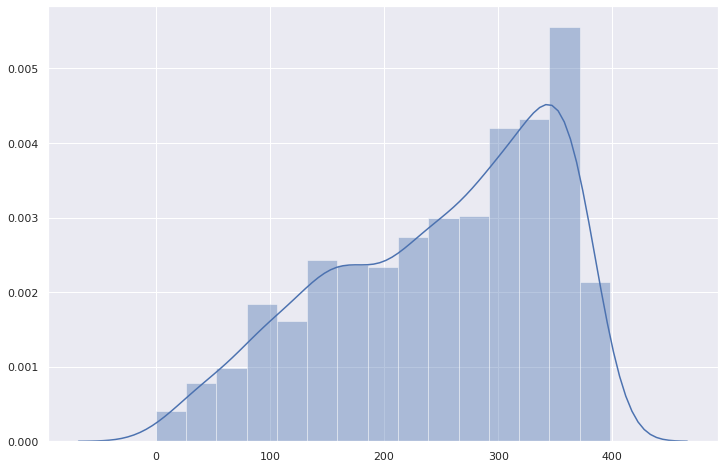

In [253]:
sns.distplot(blitz_times)

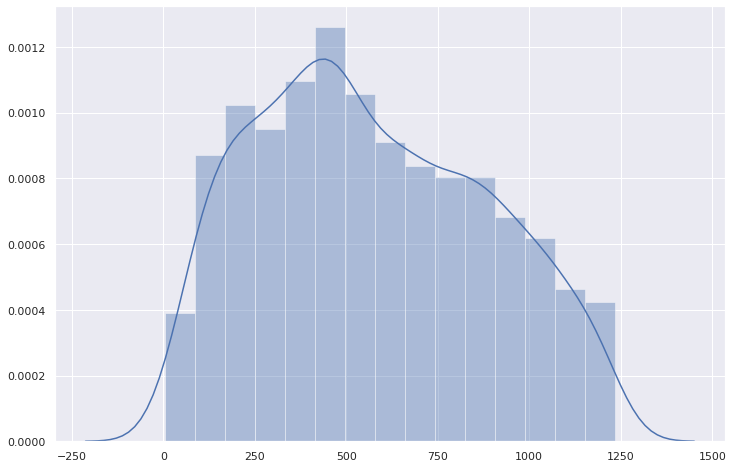

In [254]:
sns.distplot(rapid_times)

### On average how long do these games last? This is important to balance the tropies earned. It looks like Bullet and rapid are pretty well balanced (without the arena issue, which we'll mention later), but blitz has too high of a reward (You can easily get two average blitz games in before the average rapid time, but rapid only awards around 60% more trophies).

In [255]:
print(f"Average bullet time {sum(bullet_times)/len(bullet_times)}")
print(f"Average blitz_time {sum(blitz_times)/len(blitz_times)}")
print(f"Average rapid time {sum(rapid_times)/len(rapid_times)}")

Average bullet time 110.51266666666666
Average blitz_time 250.23
Average rapid time 569.1426666666666


### Now comes the main logic for simulating an arena. Logic is pretty simple: 
1. Each time we need a new game take some time to connect (in my examples I used 3 secs)
2. Draw a random game time and see if you can complete it
3. If you can't and there's time to connect to the game accept the draw
4. If the game can be completed draw from a multinomial and see the result
5. Using the win streak and result give trophy points until you can't play any more games

### We also use a arena config dictionary so we'll be able to easily configure how we'd like to change our simulation.

In [256]:
import random

import numpy as np


def simulate_game(win_percentage, draw_percentage):
    sample = np.random.multinomial(1, [win_percentage, draw_percentage, 1-(win_percentage+draw_percentage)], size=1)[0]
    if sample[0] == 1:
        return "win"
    elif sample[1] == 1:
        return "draw"
    else:
        return "loss"
    
    
def simulate_arena(arena_config, loss_prevention=False):
    cur_time = 0
    win_streak = 0
    reward = 0
    while True:
        cur_time += arena_config['search_time']
        game_length = random.choice(arena_config['game_times'])
        #Game won't finish so leave loop and return reward
        if cur_time+game_length >= arena_config['arena_length']:
            #Assume players want draw points instead of nothing
            if cur_time < arena_config['arena_length']:
                reward += arena_config['rewards']['draw']
            break
        cur_time += game_length
        result = simulate_game(arena_config['win_percent'], arena_config['draw_percent'])
        if result == 'win':
            win_streak += 1
            win_streak_num = min(3, win_streak)
            reward += arena_config['rewards']['win'][win_streak_num]
        else:
            win_streak = 0
            reward += arena_config['rewards'][result]
        if loss_prevention:
            #Make it so you can't lose trophies in an arena
            reward = max(0, reward)
    #Want to return trophies earned per hour
    return (60*60*reward)/arena_config['arena_length']

arena_config = {
    'game_times': blitz_times,
    'search_time': 3,
    'arena_length': 30*60,
    'win_percent': .5,
    'draw_percent': .1,
    'rewards': {
        'win': {1: 5, 2:6, 3:7},
        'draw': 2,
        'loss': 0
    }
}

simulate_arena(arena_config)

38.0

### We'd like to create a bunch of these configs with our different winning percentages, so we do just that with some helper functions.

In [257]:
def construct_arena_config(
    game_times,
    search_time,
    arena_length,
    win_percent,
    draw_percent,
    rewards
):
    return {
        'game_times': game_times,
        'search_time': search_time,
        'arena_length': arena_length,
        'win_percent': win_percent,
        'draw_percent': draw_percent,
        'rewards': rewards
    }


def construct_grid_search(
    default_arena_config,
    win_percentages
):
    return [ 
        construct_arena_config(
            default_arena_config['game_times'],
            default_arena_config['search_time'],
            default_arena_config['arena_length'],
            win_percent,
            default_arena_config['draw_percent'],
            default_arena_config['rewards']
        ) for win_percent in win_percentages
    ]


bullet_default_config = {
    'game_times': bullet_times,
    'search_time': 3,
    'arena_length': 30*60,
    'win_percent': .5,
    'draw_percent': .1,
    'rewards': {
        'win': {1: 5, 2:6, 3:7},
        'draw': 2,
        'loss': 0
    }
}

blitz_default_config = {
    'game_times': blitz_times,
    'search_time': 3,
    'arena_length': 60*60,
    'win_percent': .5,
    'draw_percent': .1,
    'rewards': {
        'win': {1: 11, 2:12, 3:13},
        'draw': 4,
        'loss': 0
    }
}

rapid_default_config = {
    'game_times': rapid_times,
    'search_time': 3,
    'arena_length': 120*60,
    'win_percent': .5,
    'draw_percent': .1,
    'rewards': {
        'win': {1: 17, 2:18, 3:19},
        'draw': 6,
        'loss': 0
    }
}

bullet_configs = construct_grid_search(bullet_default_config, [ i/100 for i in range(20, 81) ])
blitz_configs = construct_grid_search(blitz_default_config, [ i/100 for i in range(20, 81) ])
rapid_configs = construct_grid_search(rapid_default_config, [ i/100 for i in range(20, 81) ])

### From there we run our simulations a number of times and get averages (in these examples I ran 1000 simulations for each win percentage).

In [258]:
import pandas as pd
from tqdm.notebook import tqdm


def run_simulations(configs, num_simulations, loss_prevention=False):
    simulation_output = {}
    for config in tqdm(configs):
        simulation_output[config['win_percent']] = [ simulate_arena(config, loss_prevention) for i in range(num_simulations) ]
    return simulation_output


def get_averages(simulations, game_type):
    output = []
    for key in simulations:
        output.append(
            {
                'game_type': game_type, 
                'win_percent': key, 
                'average_trophies_per_hour': sum(simulations[key])/len(simulations[key]),
                'median_trophies_per_hour': np.median(simulations[key])
            }
        )
    return pd.DataFrame.from_dict(output)
        
                        
bullet_simulations = run_simulations(bullet_configs, 1000)
bullet_averages = get_averages(bullet_simulations, 'bullet')
blitz_simulations = run_simulations(blitz_configs, 1000)
blitz_averages = get_averages(blitz_simulations, 'blitz')
rapid_simulations = run_simulations(rapid_configs, 1000)
rapid_averages = get_averages(rapid_simulations, 'rapid')

chess_league_trophy_df = pd.concat([bullet_averages, blitz_averages, rapid_averages])
chess_league_trophy_df.head()

game_type  win_percent  average_trophies_per_hour  median_trophies_per_hour
0    bullet         0.20                     42.362                      40.0
1    bullet         0.21                     43.728                      42.0
2    bullet         0.22                     45.066                      44.0
3    bullet         0.23                     47.186                      46.0
4    bullet         0.24                     49.426                      48.0

### We then plot our trophies by winning percentage for each game type.

Text(0.5, 1.0, 'Average League Points Per Hour (Chess.com Point System)')

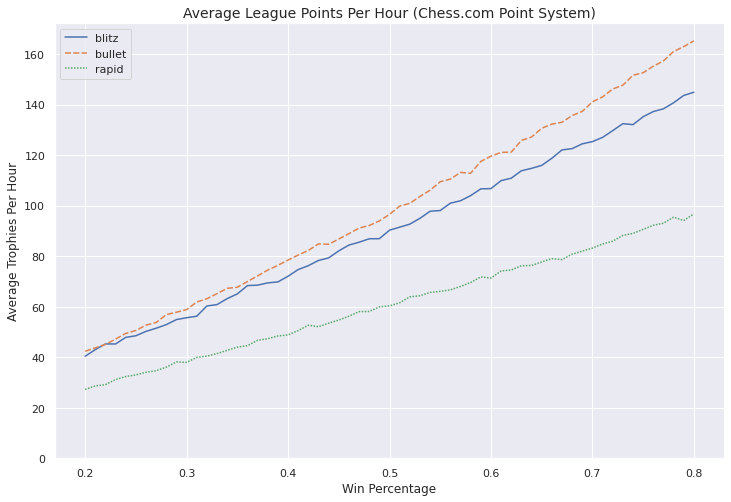

In [272]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

chess_league_trophy_wide = chess_league_trophy_df.pivot("win_percent", "game_type", "average_trophies_per_hour")
sns.set_style("darkgrid")

sns.set(rc = {'figure.figsize':(12,8)})
sns.set_context("notebook")
chess_league_plot = sns.lineplot(data=chess_league_trophy_wide)
chess_league_plot.set(
    xlabel="Win Percentage", 
    ylabel="Average Trophies Per Hour", 
    ylim=0, 
    title='Average League Points Per Hour (Chess.com Point System)',
)
chess_league_plot.set_title('Average League Points Per Hour (Chess.com Point System)', fontsize = 14)

### Bullet games seem the way to go with blitz games being somewhat close. Rapid games (at least according to our simulation) are by far the worst way to accumulate points. The broader problem seems to be how the extra arena trophies are allocated. Trophies scale with game length, but the arena bonus points do not, and worse, the quickness of the bullet games allow more games to be played increasing the chances for streaks (you can play 15 bullet games in 30 mins, but only six rapid games in two hours if they all go to full time).

### So what about other scoring systems? How do the rewards change if we allow trophies to be taken away for loses?

### I imagined two ways of this working. The first allows one to earn negative trophies from an arena. We do this by chaning our arena config reward to be the negative of the first win (without the arena bonus).

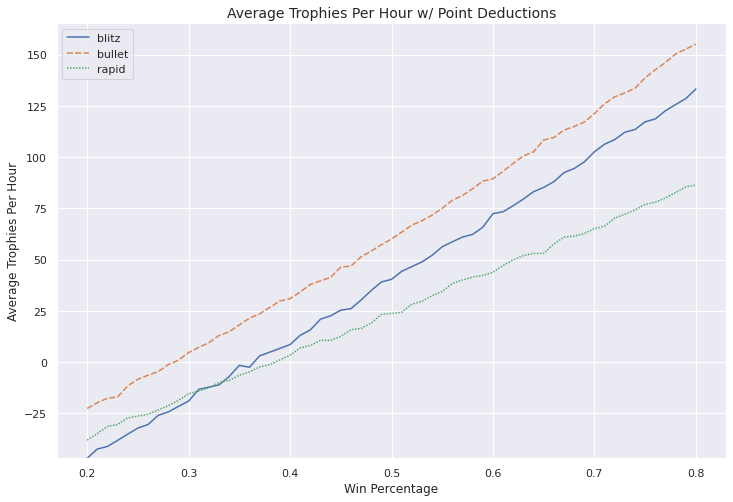

In [275]:
import copy


def create_grid_searches(
    bullet_default_config,
    blitz_default_config,
    rapid_default_config
):
    bullet_configs = construct_grid_search(bullet_default_config, [ i/100 for i in range(20, 81) ])
    blitz_configs = construct_grid_search(blitz_default_config, [ i/100 for i in range(20, 81) ])
    rapid_configs = construct_grid_search(rapid_default_config, [ i/100 for i in range(20, 81) ])
    return bullet_configs, blitz_configs, rapid_configs
    

def run_trophy_average_process(
    bullet_default_config,
    blitz_default_config,
    rapid_default_config,
    num_simulations = 1000,
    loss_prevention = False,
):
    bullet_configs, blitz_configs, rapid_configs = create_grid_searches(
        bullet_default_config, blitz_default_config, rapid_default_config
    )
    bullet_simulations = run_simulations(bullet_configs, num_simulations, loss_prevention)
    bullet_averages = get_averages(bullet_simulations, 'bullet')
    blitz_simulations = run_simulations(blitz_configs, num_simulations, loss_prevention)
    blitz_averages = get_averages(blitz_simulations, 'blitz')
    rapid_simulations = run_simulations(rapid_configs, num_simulations, loss_prevention)
    rapid_averages = get_averages(rapid_simulations, 'rapid')
    trophy_df = pd.concat([bullet_averages, blitz_averages, rapid_averages])
    return trophy_df
    

def plot_trophy_df(t_df, title="Average Trophies Per Hour", metric="average_trophies_per_hour", axis=None):
    trophy_wide = t_df.pivot("win_percent", "game_type", metric)
    sns.set_style("darkgrid")
    sns.set(rc = {'figure.figsize':(12,8)})
    if axis:
        plot = sns.lineplot(data=trophy_wide, ax=axis)
    else:
        plot = sns.lineplot(data=trophy_wide)
    plot.set(
        xlabel="Win Percentage", 
        ylabel="Average Trophies Per Hour", 
        ylim=min(0, t_df['average_trophies_per_hour'].min()), 
    )
    plot.set_title(title, fontsize=14)
    return plot
    
neg_bullet_default_config = copy.deepcopy(bullet_default_config)
neg_bullet_default_config['rewards']['loss'] = -3
neg_blitz_default_config = copy.deepcopy(blitz_default_config)
neg_blitz_default_config['rewards']['loss'] = -9
neg_rapid_default_config = copy.deepcopy(rapid_default_config)
neg_rapid_default_config['rewards']['loss'] = -15

negative_trophy_df = run_trophy_average_process(neg_bullet_default_config, neg_blitz_default_config, neg_rapid_default_config)
neg_trophy_plot = plot_trophy_df(negative_trophy_df, "Average Trophies Per Hour w/ Point Deductions")
neg_trophy_plot

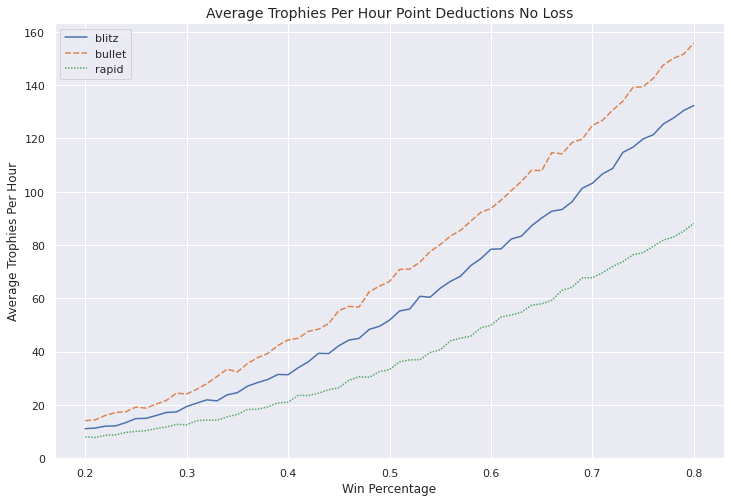

In [276]:
neg_loss_trophy_df = run_trophy_average_process(
    neg_bullet_default_config, neg_blitz_default_config, neg_rapid_default_config, loss_prevention=True)
neg_loss_prev_trophy_plot = plot_trophy_df(neg_loss_trophy_df, 'Average Trophies Per Hour Point Deductions No Loss')
neg_loss_prev_trophy_plot

### We still have a large divergence between the game points, but the negative trophies with the clamp at zero seem to have the nice side effect of making it much more strategic to try to win more games.

### I then tried messing around with the points to balance the game types. I found a very small increase for blitz got us there, but nearly had to double the rapid points to get it on par. The more elegant solution might be a multiplier for the longer time controls on arena points (as we see later without these points blitz is a bit too rewarding, but rapid and bullet are on par).

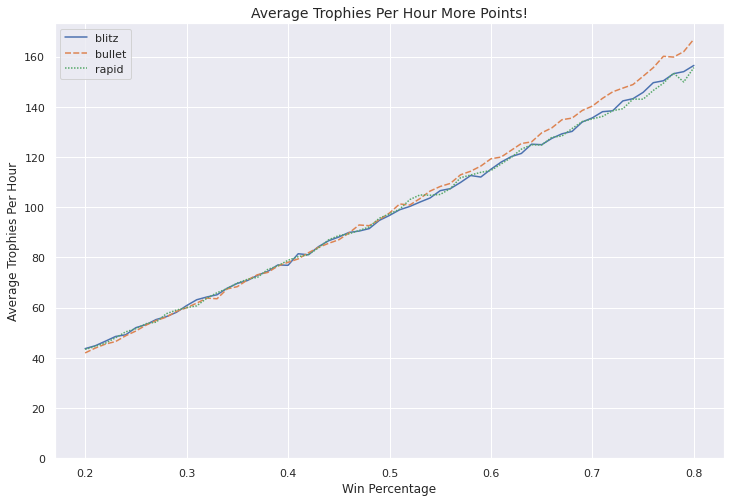

In [277]:
win_more_blitz_default_config = copy.deepcopy(blitz_default_config)
win_more_blitz_default_config['rewards']['win'] = {1: 12, 2:13, 3:14}
win_more_rapid_default_config = copy.deepcopy(rapid_default_config)
win_more_rapid_default_config['rewards']['win'] = {1: 29, 2:30, 3:31}
win_more_trophy_df = run_trophy_average_process(bullet_default_config, win_more_blitz_default_config, win_more_rapid_default_config)
win_more_trophy_plot = plot_trophy_df(win_more_trophy_df, "Average Trophies Per Hour More Points!")
win_more_trophy_plot

### What if we take away the arena bonus? Well, blitz becomes much stronger than everything else. This seems to be from the scraped blitz games on average being much quicker than their time control compared to rapid or bullet.

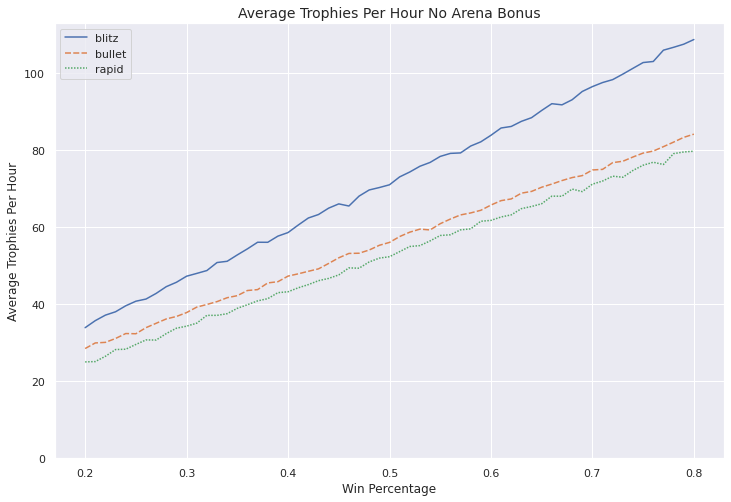

In [278]:
no_arena_bullet_default_config = copy.deepcopy(bullet_default_config)
no_arena_bullet_default_config['rewards']['win'] = {1: 3, 2:3, 3:3}
no_arena_blitz_default_config = copy.deepcopy(blitz_default_config)
no_arena_blitz_default_config['rewards']['win'] = {1: 9, 2:9, 3:9}
no_arena_rapid_default_config = copy.deepcopy(rapid_default_config)
no_arena_rapid_default_config['rewards']['win'] = {1: 15, 2:15, 3:15}
no_arena_trophy_df = run_trophy_average_process(
    no_arena_bullet_default_config, no_arena_blitz_default_config, no_arena_rapid_default_config)
no_arena_trophy_plot = plot_trophy_df(no_arena_trophy_df, "Average Trophies Per Hour No Arena Bonus")
no_arena_trophy_plot

### Finally, we save a stacked figure of the current league system with the best strategies for the arena, and for not having arena points (substitute for queueing with play instead of an arena)

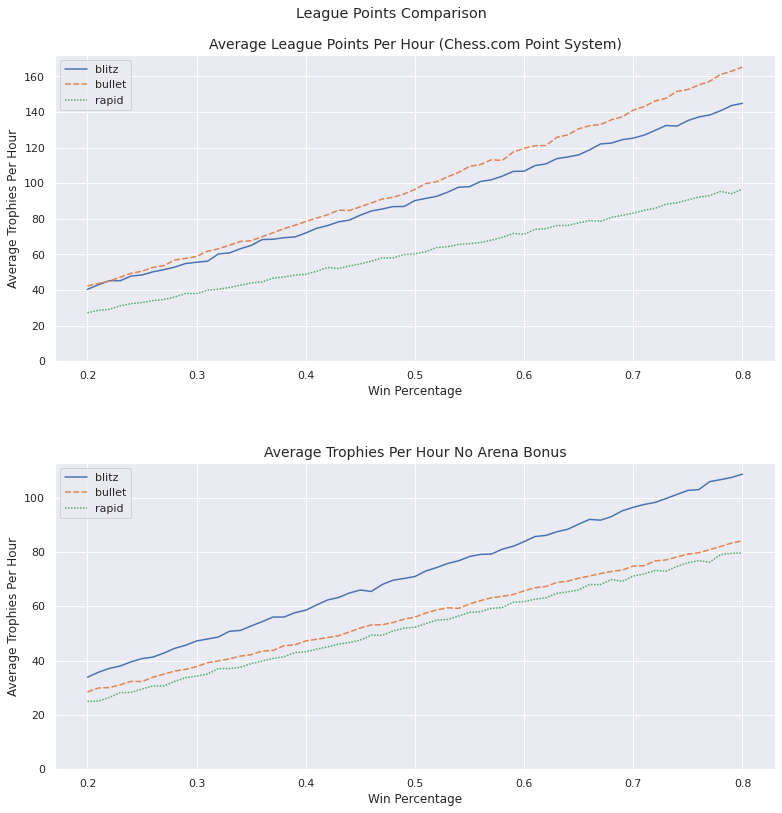

In [279]:
sns.set(rc = {'figure.figsize':(12,12)})
fig, axs = plt.subplots(2)
fig.suptitle('League Points Comparison')

plot_trophy_df(chess_league_trophy_df, "Average League Points Per Hour (Chess.com Point System)", axis=axs[0])
plot_trophy_df(no_arena_trophy_df, "Average Trophies Per Hour No Arena Bonus", axis=axs[1])
fig.tight_layout(pad=4.0)

In [280]:
fig.savefig("trophy_comparison.png")

## Key Takeaways
1. Bullet arenas are the most time effective way to earn league trophies
2. Rapid seems overbalanced and could probably use a few more points for wins
3. Without arena bonus, blitz games are the most effective

### These come with the caveat that our simulation doesn't incorporate the ability of the player to react to the given reward systems. For example, if a player was able to win rapid arenas taking only a minute, that would surely be a better strategy. We assume here that game times stay similar to the random sample we got around my ELO.

## Potential Improvements
1. Better simulation of game times using a fitted distribution rather than randomly sampling previous games
2. Moving from a fixed game-wait to a distribution of game waits could impact the difference between bullet and rapid (I expect higher game waits could make the difference on the number of games in an arena for example)
3. More accurate modeling of how players react in the end of arenas

## These observations are informed by my simulation, but chess.com has access to their entire database and the relevant analytics, so it could be entirely the case that in reality, the beta test and underlying analytics support the given reward structure, and using those would be a better balancing regime than a more sophisticated model.

## I'm excited to see the approaches used by players to maximize their trophies, and am interested to see if chess.com will make any balancing decisions in the upcoming weeks.